# Improving biomechanics research with machine learning

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-the-data" data-toc-modified-id="Get-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get the data</a></span></li><li><span><a href="#Quick-data-description" data-toc-modified-id="Quick-data-description-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Quick data description</a></span></li><li><span><a href="#Standard-biomechanics-analysis" data-toc-modified-id="Standard-biomechanics-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Standard biomechanics analysis</a></span><ul class="toc-item"><li><span><a href="#Paired-Hotelling’s-T2-test" data-toc-modified-id="Paired-Hotelling’s-T2-test-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Paired Hotelling’s T2 test</a></span></li><li><span><a href="#Paired-t-test" data-toc-modified-id="Paired-t-test-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Paired t test</a></span></li></ul></li><li><span><a href="#Fitting-a-linear-model" data-toc-modified-id="Fitting-a-linear-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fitting a linear model</a></span></li><li><span><a href="#Fitting-an-ensemble-model" data-toc-modified-id="Fitting-an-ensemble-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Fitting an ensemble model</a></span><ul class="toc-item"><li><span><a href="#Fitting-a-boosted-tree" data-toc-modified-id="Fitting-a-boosted-tree-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Fitting a boosted tree</a></span></li><li><span><a href="#Interpreting-a-boosted-tree" data-toc-modified-id="Interpreting-a-boosted-tree-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Interpreting a boosted tree</a></span><ul class="toc-item"><li><span><a href="#How-important-are-our-features?" data-toc-modified-id="How-important-are-our-features?-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>How important are our features?</a></span></li><li><span><a href="#What-is-the-prediction-path?" data-toc-modified-id="What-is-the-prediction-path?-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>What is the prediction path?</a></span></li><li><span><a href="#How-is-target-variable-related-with-important-features?" data-toc-modified-id="How-is-target-variable-related-with-important-features?-5.2.3"><span class="toc-item-num">5.2.3&nbsp;&nbsp;</span>How is target variable related with important features?</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import scipy.io as sio
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline
# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Get the data

In [2]:
DATA_PATH = Path('./data')
DATA_FILE = 'DataBaseRPT'

mat = sio.loadmat(f'{DATA_PATH / DATA_FILE}.mat')[DATA_FILE][0, 0]

y = mat['Y'].T

col_names = [i[0] for i in mat['CAssignAll'].flatten()]
X = pd.DataFrame(mat['AllX'].T, columns=col_names)
X['sex'] = mat['Sex'].T
X.head()

,AveElbFlexMean,ROMElbFlexMean,AveElbFlexSD,ROMElbFlexSD,AveShPlaneMean,ROMShPlaneMean,AveShPlaneSD,ROMShPlaneSD,AveShEleMean,ROMShEleMean,...,ROMTrXSD,AveTrYMean,ROMTrYMean,AveTrYSD,ROMTrYSD,AveTrZMean,ROMTrZMean,AveTrZSD,ROMTrZSD,sex
0,105.983144,63.339618,2.219401,1.794134,23.518597,13.624799,1.338393,2.357813,80.274017,2.942674,...,0.321233,16.382423,13.629558,1.112671,1.977798,-0.550047,2.671822,0.228494,0.711787,2
1,106.166216,61.875226,2.239310,2.548458,22.851141,11.726534,1.182490,1.401127,77.897777,4.062635,...,0.617063,16.041630,15.078508,0.910697,1.003788,-0.208865,1.242553,0.541000,0.496108,2
2,100.914284,60.930029,1.482458,1.167593,27.289316,12.291697,1.223189,2.452705,83.932823,2.886935,...,0.327905,15.039772,14.311074,0.979720,2.070705,0.096174,0.934767,0.488540,0.317386,2
3,105.066549,59.524098,2.364182,1.849991,23.083816,7.519415,1.510000,3.503819,78.701025,2.997990,...,0.487730,16.070120,16.178023,1.418294,3.521951,-0.544067,1.885480,0.610577,0.851287,2
4,93.259333,81.531138,2.610755,3.632922,42.387152,27.789377,1.605530,2.027628,71.280986,8.000008,...,0.483336,8.908385,8.815273,0.709582,1.250228,-0.123442,1.065910,0.415764,0.404298,2


## Quick data description

We want to predict `y` (fatigue) from `X`
- `Y` (1, 162): 1 = prefatigue, 2 = fatigue
- `X` (24, 162): 24 (6 DoF x 4 variables) x 162 (81 participants x 2 time points)


In [3]:
X.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
AveElbFlexMean,162.0,87.683519,10.938762,63.370465,78.851127,87.221130,95.923268,111.631308
ROMElbFlexMean,162.0,78.862532,12.047902,50.125251,71.048711,79.202813,88.286513,106.249635
AveElbFlexSD,162.0,2.873665,1.053757,0.467918,2.215573,2.734158,3.453785,6.117484
ROMElbFlexSD,162.0,2.853841,1.204700,0.592176,2.054954,2.600875,3.479937,9.644025
AveShPlaneMean,162.0,39.611639,10.067441,14.505774,33.709127,39.202013,46.599549,60.477201
ROMShPlaneMean,162.0,26.605236,8.721028,4.676731,21.237682,26.627400,33.265735,53.387836
AveShPlaneSD,162.0,1.834459,0.845747,0.156498,1.227546,1.635454,2.246692,5.043419
ROMShPlaneSD,162.0,2.994131,1.302354,0.550009,2.104472,2.676904,3.705648,8.957279
AveShEleMean,162.0,81.147580,7.622477,61.437129,75.760545,81.399549,86.281279,106.876856
ROMShEleMean,162.0,5.470404,3.391452,1.438936,3.378308,4.686520,6.153450,22.494075


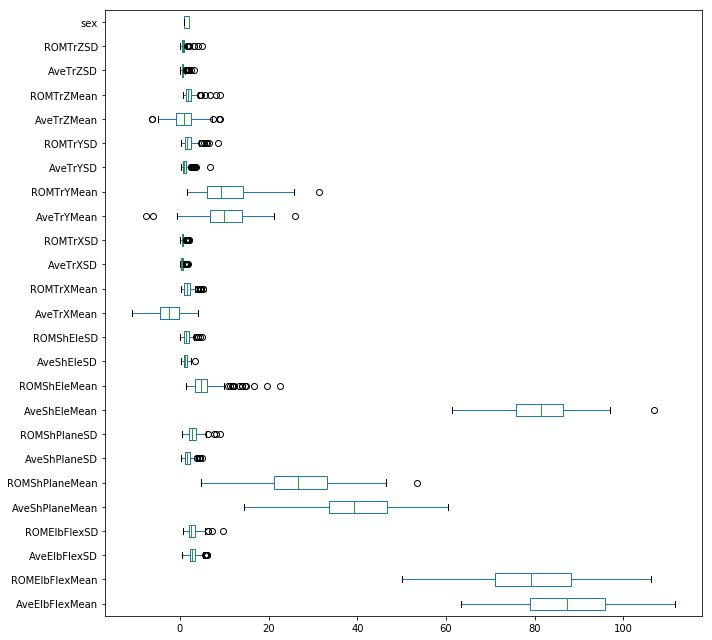

In [4]:
X.plot(kind='box', vert=False, figsize=(10, 9))
plt.tight_layout()

## Standard biomechanics analysis
Using frequentist to detect which variables change between a subject with fatigue and without fatigue

In [5]:
import spm1d
alpha = 0.05
iterations = 10000

### Paired Hotelling’s T2 test
Multivariate test

In [6]:
# (J x Q x I) arrays
# J = number of 1D responses
# Q = number of nodes to which the 1D responses have been resampled
# I = number of vector components

# create 3D
yA = X[y == 1].drop('sex', axis=1).values  # pre-fatigue
yB = X[y == 2].drop('sex', axis=1).values  # fatigue

In [7]:
hotelling = spm1d.stats.nonparam.hotellings_paired(yA, yB)
hotellingi = hotelling.inference(alpha, iterations)
if hotellingi.h0reject:
    print(
        f'\th0 rejected, variables with fatigue != without fatigue (p={hotellingi.p})'
    )
else:
    print(
        f'\th0 not rejected, variables with fatigue == without fatigue (p={hotellingi.p})'
    )

	h0 rejected, variables with fatigue != without fatigue (p=0.0001)


As the hotelling ttest reaches significance, we can conduct separate paired t-tests on each pair of variables

### Paired t test

In [8]:
for ivar in range(yA.shape[1] - 1):
    A = yA[:, ivar]
    B = yB[:, ivar]
    ttest = spm1d.stats.nonparam.ttest_paired(A, B)
    ttesti = ttest.inference(alpha=alpha, iterations=iterations)
    print(f'{ivar+1}.{"-"*10}')
    if ttesti.h0reject:
        if B.mean() > A.mean():
            direction = '>'
        else:
            direction = '<'
        print(
            f'\th0 rejected, {col_names[ivar]} with fatigue {direction} without fatigue (p={ttesti.p})'
        )
    else:
        print(
            f'\th0 not rejected, {col_names[ivar]} with fatigue == without fatigue (p={ttesti.p})'
        )

1.----------
	h0 rejected, AveElbFlexMean with fatigue > without fatigue (p=0.0044)
2.----------
	h0 rejected, ROMElbFlexMean with fatigue < without fatigue (p=0.0044)
3.----------
	h0 not rejected, AveElbFlexSD with fatigue == without fatigue (p=0.187)
4.----------
	h0 rejected, ROMElbFlexSD with fatigue > without fatigue (p=0.0001)
5.----------
	h0 rejected, AveShPlaneMean with fatigue < without fatigue (p=0.003)
6.----------
	h0 rejected, ROMShPlaneMean with fatigue < without fatigue (p=0.012)
7.----------
	h0 rejected, AveShPlaneSD with fatigue > without fatigue (p=0.0038)
8.----------
	h0 rejected, ROMShPlaneSD with fatigue > without fatigue (p=0.0001)
9.----------
	h0 rejected, AveShEleMean with fatigue < without fatigue (p=0.0001)
10.----------
	h0 rejected, ROMShEleMean with fatigue > without fatigue (p=0.0001)
11.----------
	h0 rejected, AveShEleSD with fatigue > without fatigue (p=0.0214)
12.----------
	h0 rejected, ROMShEleSD with fatigue > without fatigue (p=0.0001)
13.----

23 paired t-test reach significance. Everything is different except `AveTrYMean` ($p=0.5068$) and `AveElbFlexSD` ($p=0.187$).

Hard to conclude anything.

## Fitting a linear model

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

binarizer = LabelBinarizer()
y = binarizer.fit_transform(y)
X['sex'] = binarizer.fit_transform(X['sex'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [10]:
lr = LogisticRegression()
lr.fit(X_train, y_train.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [11]:
from sklearn.metrics import classification_report

print(classification_report(y_test, lr.predict(X_test)))

             precision    recall  f1-score   support

          0       0.71      0.59      0.65        17
          1       0.63      0.75      0.69        16

avg / total       0.67      0.67      0.66        33



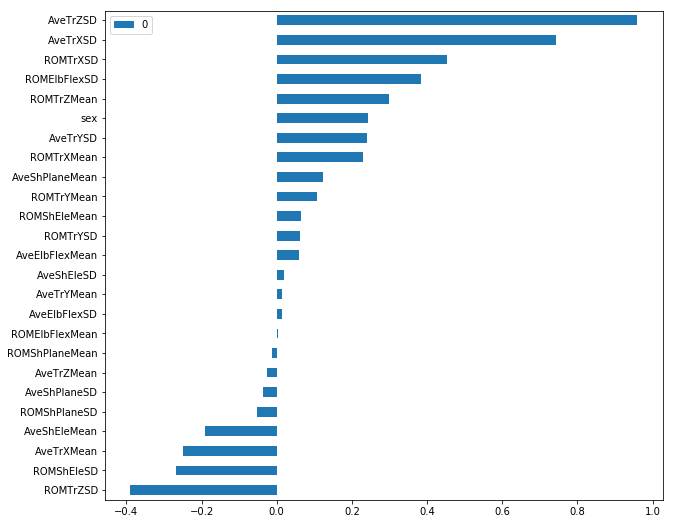

In [12]:
coeffs = pd.DataFrame(lr.coef_, columns=X.columns)
coeffs.T.sort_values(by=0).plot(
    kind='barh', figsize=(10, 9));

In accordance with the previous stats, `AveTrYMean` and `AveElbFlexSD` are indeed useless.

We can hypothesize that `ROMTrZSD` and `AVeTrZSD` are important features.
However, our model is not so predictive ($0.67$ precision and recall).


A common mistake is to interpret coefficients a non-scaled data.
We have to normalize the data and the coefficients.

             precision    recall  f1-score   support

          0       0.87      0.76      0.81        17
          1       0.78      0.88      0.82        16

avg / total       0.82      0.82      0.82        33



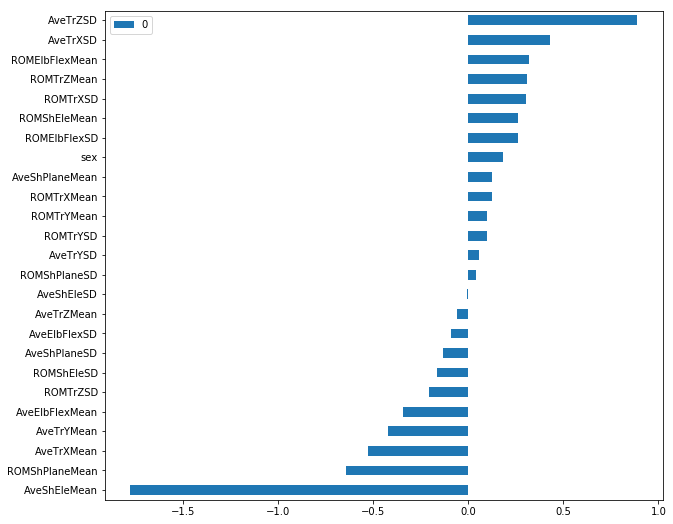

In [13]:
from sklearn.preprocessing import StandardScaler
# Now we normalise the data
scalerX = StandardScaler().fit(X_train)

normed_X_train = scalerX.transform(X_train)

lr_scaled = LogisticRegression()
lr_scaled.fit(normed_X_train, y_train.ravel())

print(classification_report(y_test, lr.predict(scalerX.transform(X_test))))

coeffs_scaled = pd.DataFrame(lr_scaled.coef_, columns=X.columns)
coeffs_scaled.T.sort_values(by=0).plot(
    kind='barh', figsize=(10, 9));

Once data are normalized, our linear model is much more predictive ($0.82$ precision and recall) and we have a whole other story about the coefficients.
`AveShEleMean` seems to be the most important feature.

But interpreting linear coefficient is a dangerous game and we should be carefull.
 
Statisticians regularly caution that coefficients cannot be assigned straightforward interpretations (Westfall & Yarkoni, 2016 ; Shear & Zumbo, 2013).
Regression models are often very unstable and can produce highly misleading conclusions

## Fitting an ensemble model

### Fitting a boosted tree

In [14]:
import xgboost

d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}

params2 = {
    'colsample_bylevel': 0.3424459200788505,
    'colsample_bytree': 1.0,
    'gamma': 3.794732662612317e-09,
    'learning_rate': 0.01945896942003687,
    'max_delta_step': 14,
    'max_depth': 50,
    'min_child_weight': 0,
    'n_estimators': 57,
    'reg_alpha': 2.7365638307224938e-06,
    'reg_lambda': 5.19307013153233e-06,
    'scale_pos_weight': 2.030651303825029,
    'subsample': 0.6177673301536395
}

boosted = xgboost.train(
    params2,
    d_train,
    num_boost_round=5000,
    evals=[(d_test, "test")],
    verbose_eval=25,
    early_stopping_rounds=100
)

[0]	test-rmse:0.49921
Will train until test-rmse hasn't improved in 100 rounds.
[25]	test-rmse:0.450716
[50]	test-rmse:0.428278
[75]	test-rmse:0.411654
[100]	test-rmse:0.40483
[125]	test-rmse:0.401049
[150]	test-rmse:0.401182
[175]	test-rmse:0.401182
[200]	test-rmse:0.400338
[225]	test-rmse:0.400645
[250]	test-rmse:0.400581
[275]	test-rmse:0.400582
Stopping. Best iteration:
[189]	test-rmse:0.39974



In [15]:
threshold = 0.7
d_predict = (boosted.predict(d_test, ntree_limit=boosted.best_iteration) > threshold).astype(int)
print(classification_report(y_test, d_predict))

             precision    recall  f1-score   support

          0       0.73      0.94      0.82        17
          1       0.91      0.62      0.74        16

avg / total       0.82      0.79      0.78        33



### Interpreting a boosted tree
Using [shap](https://arxiv.org/abs/1802.03888)

In [16]:
import shap
# load JS visualization code to notebook
shap.initjs()

#### How important are our features?

The units of the SHAP values for this model are log odds ratios. Large positive values mean an observation is likely to get fatigue.

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample.

The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output.

The color represents the feature value (red high, blue low).

This reveals for example that a high `AveShEleMean` lowers the predicted fatigue.


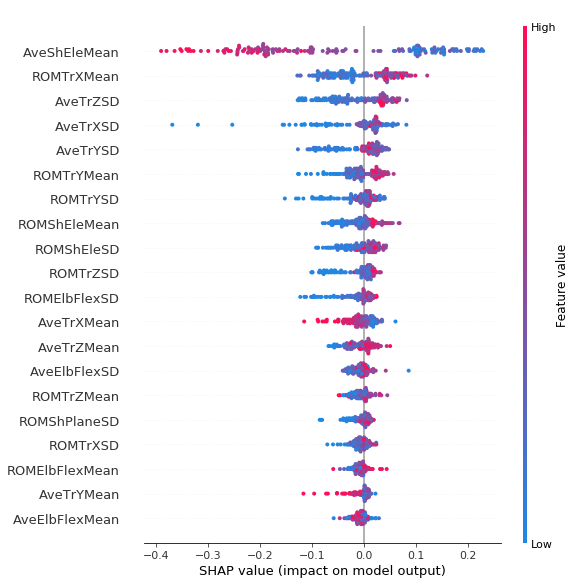

In [17]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(boosted)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X)

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot:

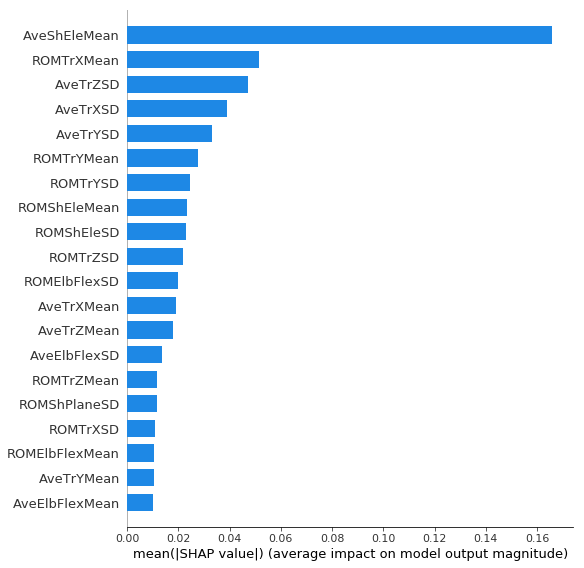

In [18]:
shap.summary_plot(shap_values, X, plot_type="bar")

From this we can select the most usefull features and re-train a model

In [19]:
usefull_features = [
    'AveShEleMean', 'ROMTrXMean', 'AveTrXSD', 'AveTrZSD', 'ROMShEleMean', 'sex'
]

X_few = X[usefull_features]

X_train, X_test, y_train, y_test = train_test_split(
    X_few, y, test_size=0.2, random_state=RANDOM_SEED)

d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

boosted = xgboost.train(
    params2,
    d_train,
    num_boost_round=5000,
    evals=[(d_test, "test")],
    verbose_eval=25,
    early_stopping_rounds=100)

[0]	test-rmse:0.495653
Will train until test-rmse hasn't improved in 100 rounds.
[25]	test-rmse:0.434481
[50]	test-rmse:0.397833
[75]	test-rmse:0.393402
[100]	test-rmse:0.392204
[125]	test-rmse:0.393458
[150]	test-rmse:0.392579
[175]	test-rmse:0.393569
Stopping. Best iteration:
[85]	test-rmse:0.390265



In [20]:
threshold = 0.7
d_predict = (boosted.predict(d_test, ntree_limit=boosted.best_iteration) > threshold).astype(int)
print(classification_report(y_test, d_predict))

             precision    recall  f1-score   support

          0       0.80      0.94      0.86        17
          1       0.92      0.75      0.83        16

avg / total       0.86      0.85      0.85        33



We get a better model by selecting usefull features.

#### What is the prediction path?

The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [21]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(boosted)
shap_values = explainer.shap_values(X_few)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_few.iloc[0,:])

In [22]:
# visualize the second prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[1,:], X_few.iloc[1,:])

The units of the SHAP values for this model are log odds ratios. Large positive values mean an observation is likely to be fatigued.

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset

In [23]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_few)

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample.

The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output.

The color represents the feature value (red high, blue low).

This reveals for example that a high `AveShEleMean` lowers the predicted fatigue.


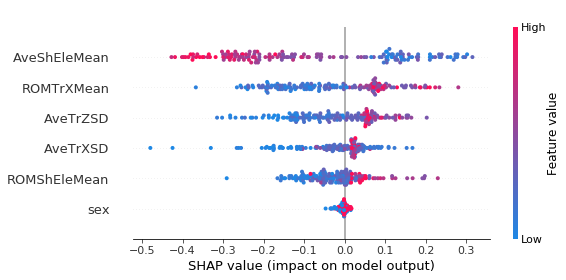

In [24]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_few)

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot:

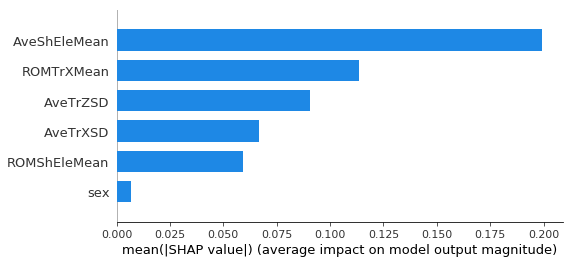

In [25]:
x = shap.summary_plot(shap_values, X_few, plot_type="bar")

#### How is target variable related with important features? 

The XGBoost model we trained above is very complicated, but by plotting the SHAP value for a feature against the actual value of the feature for all observations we can see how changes in the feature's value effect the model's output.

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset.

Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in fatigue as `AveShEleMean` changes.

Vertical dispersion at a single value of `AveShEleMean` represents interaction effects with other features.

To help reveal these interactions dependence_plot automatically selects another feature for coloring.

In this case coloring by `ROMTrYMean` highlights that `AveShEleMean` has less impact on fatigue when `ROMTrXMean` decreases and conversely.

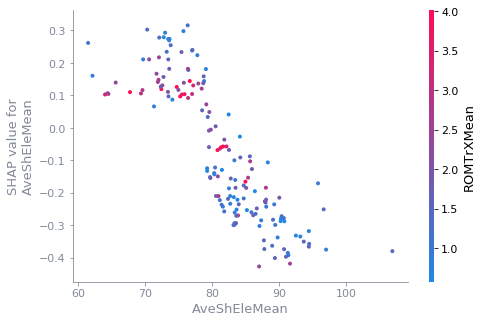

In [26]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("AveShEleMean", shap_values, X_few)

the plot below represents the change in fatigue as `AveShEleMean` changes with the interaction of `sex`.

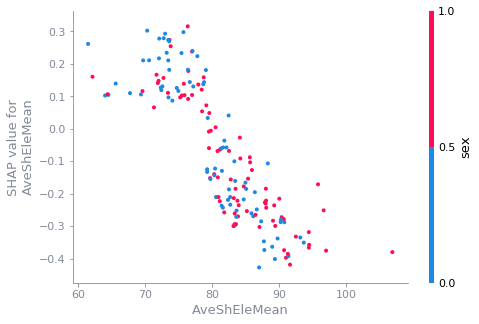

In [27]:
shap.dependence_plot("AveShEleMean", shap_values, X_few, interaction_index='sex')

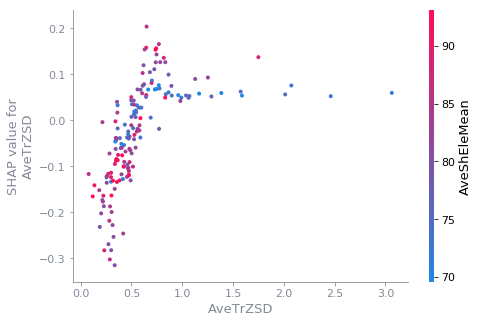

In [28]:
shap.dependence_plot("AveTrZSD", shap_values, X_few)

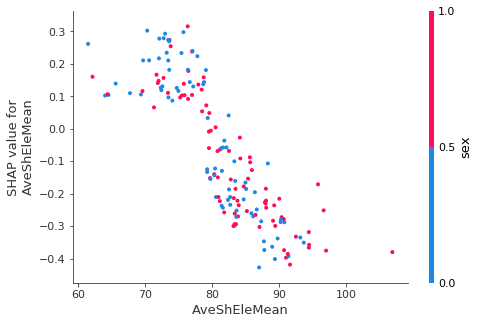

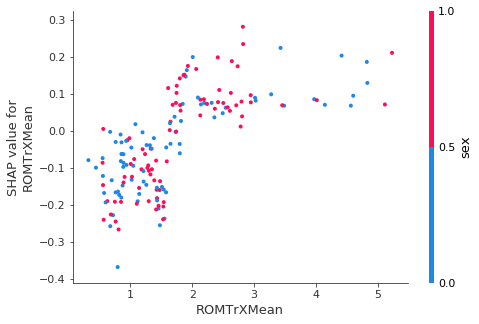

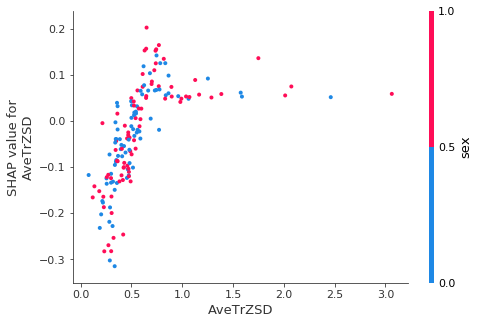

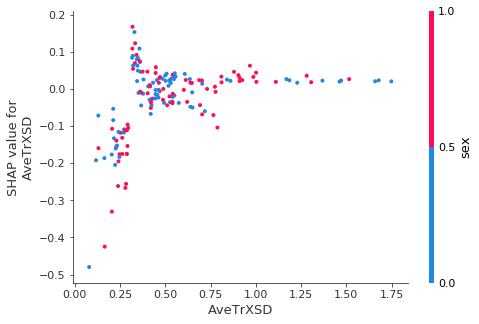

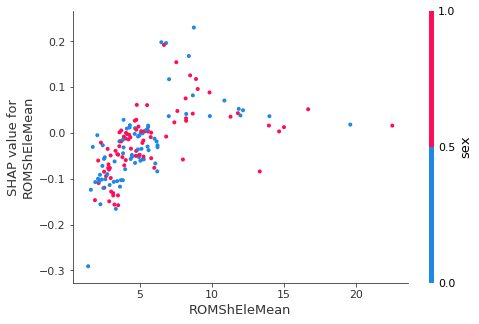

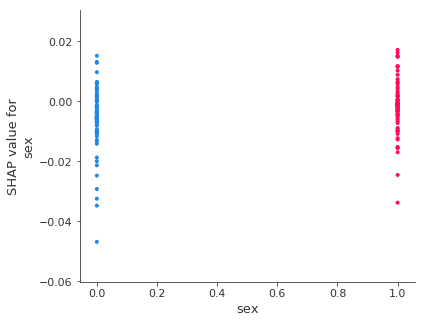

In [29]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the five most important features and interaction with the sex feature
for i in top_inds:
    shap.dependence_plot(i, shap_values, X_few, interaction_index='sex')

In [32]:
# Hyperparameter optimization
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV

ITERATIONS = 100

bayes_cv_tuner = BayesSearchCV(
    estimator=XGBClassifier(
        n_jobs=1,
        objective='binary:logistic',
        eval_metric='auc',
        silent=1,
        tree_method='approx'),
    search_spaces={
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (0, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (50, 100),
        'scale_pos_weight': (1e-6, 500, 'log-uniform')
    },
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=3,
    n_iter=ITERATIONS,
    verbose=0,
    refit=True,
    random_state=42)


def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""

    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)

    # Get current parameters and the best parameters
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models), np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_))

    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name + "_cv_results.csv")


result = bayes_cv_tuner.fit(X_train, y_train.ravel(), callback=status_print)

Model #1
Best ROC-AUC: 0.5
Best params: {'colsample_bylevel': 0.4160029192647807, 'colsample_bytree': 0.7304484857455519, 'gamma': 0.13031389926541354, 'learning_rate': 0.042815319280763466, 'max_delta_step': 13, 'max_depth': 21, 'min_child_weight': 2, 'n_estimators': 87, 'reg_alpha': 5.497557739289786e-07, 'reg_lambda': 0.05936070635912049, 'scale_pos_weight': 0.060830282487222144, 'subsample': 0.13556548021189216}

Model #2
Best ROC-AUC: 0.8881
Best params: {'colsample_bylevel': 0.8390144719977516, 'colsample_bytree': 0.8844821246070537, 'gamma': 4.358684608480795e-07, 'learning_rate': 0.7988179462781242, 'max_delta_step': 17, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 68, 'reg_alpha': 0.0005266983003701547, 'reg_lambda': 276.5424475574225, 'scale_pos_weight': 0.3016410771843142, 'subsample': 0.9923710598637134}

Model #3
Best ROC-AUC: 0.8947
Best params: {'colsample_bylevel': 0.4503841871781403, 'colsample_bytree': 0.9195352964526833, 'gamma': 8.168958221061441e-09, 'lea

Model #21
Best ROC-AUC: 0.9104
Best params: {'colsample_bylevel': 0.8292854936654052, 'colsample_bytree': 0.6379508921150754, 'gamma': 1.026279420540916e-05, 'learning_rate': 0.667466816392664, 'max_delta_step': 20, 'max_depth': 40, 'min_child_weight': 0, 'n_estimators': 85, 'reg_alpha': 9.714549195336604e-09, 'reg_lambda': 42.332279215580016, 'scale_pos_weight': 1.8226995271303308, 'subsample': 1.0}

Model #22
Best ROC-AUC: 0.9104
Best params: {'colsample_bylevel': 0.8292854936654052, 'colsample_bytree': 0.6379508921150754, 'gamma': 1.026279420540916e-05, 'learning_rate': 0.667466816392664, 'max_delta_step': 20, 'max_depth': 40, 'min_child_weight': 0, 'n_estimators': 85, 'reg_alpha': 9.714549195336604e-09, 'reg_lambda': 42.332279215580016, 'scale_pos_weight': 1.8226995271303308, 'subsample': 1.0}

Model #23
Best ROC-AUC: 0.9104
Best params: {'colsample_bylevel': 0.8292854936654052, 'colsample_bytree': 0.6379508921150754, 'gamma': 1.026279420540916e-05, 'learning_rate': 0.6674668163926

Model #42
Best ROC-AUC: 0.9104
Best params: {'colsample_bylevel': 0.8292854936654052, 'colsample_bytree': 0.6379508921150754, 'gamma': 1.026279420540916e-05, 'learning_rate': 0.667466816392664, 'max_delta_step': 20, 'max_depth': 40, 'min_child_weight': 0, 'n_estimators': 85, 'reg_alpha': 9.714549195336604e-09, 'reg_lambda': 42.332279215580016, 'scale_pos_weight': 1.8226995271303308, 'subsample': 1.0}

Model #43
Best ROC-AUC: 0.9104
Best params: {'colsample_bylevel': 0.8292854936654052, 'colsample_bytree': 0.6379508921150754, 'gamma': 1.026279420540916e-05, 'learning_rate': 0.667466816392664, 'max_delta_step': 20, 'max_depth': 40, 'min_child_weight': 0, 'n_estimators': 85, 'reg_alpha': 9.714549195336604e-09, 'reg_lambda': 42.332279215580016, 'scale_pos_weight': 1.8226995271303308, 'subsample': 1.0}

Model #44
Best ROC-AUC: 0.9104
Best params: {'colsample_bylevel': 0.8292854936654052, 'colsample_bytree': 0.6379508921150754, 'gamma': 1.026279420540916e-05, 'learning_rate': 0.6674668163926

Model #63
Best ROC-AUC: 0.9104
Best params: {'colsample_bylevel': 0.8292854936654052, 'colsample_bytree': 0.6379508921150754, 'gamma': 1.026279420540916e-05, 'learning_rate': 0.667466816392664, 'max_delta_step': 20, 'max_depth': 40, 'min_child_weight': 0, 'n_estimators': 85, 'reg_alpha': 9.714549195336604e-09, 'reg_lambda': 42.332279215580016, 'scale_pos_weight': 1.8226995271303308, 'subsample': 1.0}

Model #64
Best ROC-AUC: 0.9104
Best params: {'colsample_bylevel': 0.8292854936654052, 'colsample_bytree': 0.6379508921150754, 'gamma': 1.026279420540916e-05, 'learning_rate': 0.667466816392664, 'max_delta_step': 20, 'max_depth': 40, 'min_child_weight': 0, 'n_estimators': 85, 'reg_alpha': 9.714549195336604e-09, 'reg_lambda': 42.332279215580016, 'scale_pos_weight': 1.8226995271303308, 'subsample': 1.0}

Model #65
Best ROC-AUC: 0.9104
Best params: {'colsample_bylevel': 0.8292854936654052, 'colsample_bytree': 0.6379508921150754, 'gamma': 1.026279420540916e-05, 'learning_rate': 0.6674668163926

Model #84
Best ROC-AUC: 0.9141
Best params: {'colsample_bylevel': 0.4532179315710175, 'colsample_bytree': 1.0, 'gamma': 9.759246909915306e-09, 'learning_rate': 0.09296273333425886, 'max_delta_step': 7, 'max_depth': 25, 'min_child_weight': 3, 'n_estimators': 61, 'reg_alpha': 1e-09, 'reg_lambda': 6.13640457462212e-08, 'scale_pos_weight': 2.8190614430391467, 'subsample': 0.9891883901119438}

Model #85
Best ROC-AUC: 0.9141
Best params: {'colsample_bylevel': 0.4532179315710175, 'colsample_bytree': 1.0, 'gamma': 9.759246909915306e-09, 'learning_rate': 0.09296273333425886, 'max_delta_step': 7, 'max_depth': 25, 'min_child_weight': 3, 'n_estimators': 61, 'reg_alpha': 1e-09, 'reg_lambda': 6.13640457462212e-08, 'scale_pos_weight': 2.8190614430391467, 'subsample': 0.9891883901119438}

Model #86
Best ROC-AUC: 0.9141
Best params: {'colsample_bylevel': 0.4532179315710175, 'colsample_bytree': 1.0, 'gamma': 9.759246909915306e-09, 'learning_rate': 0.09296273333425886, 'max_delta_step': 7, 'max_depth': 2

In [66]:
bayes_cv_tuner.best_params_

{'colsample_bylevel': 0.3424459200788505,
 'colsample_bytree': 1.0,
 'gamma': 3.794732662612317e-09,
 'learning_rate': 0.01945896942003687,
 'max_delta_step': 14,
 'max_depth': 50,
 'min_child_weight': 0,
 'n_estimators': 57,
 'reg_alpha': 2.7365638307224938e-06,
 'reg_lambda': 5.19307013153233e-06,
 'scale_pos_weight': 2.030651303825029,
 'subsample': 0.6177673301536395}